In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/forcasting-real-estate-lstm/Pakistan House Prices.csv


# Table of Contents
# 1. Load Dataset 
# 2. Data Exploration
# 3. Handle Missing Values
# 4. Separate Sale and Rent Data
# 5. Data Preprocessing
# 6. Detect and Handle Outliers
# 7. Feature Scaling
# 8. Time-Series Aggregation
# 9. ARIMA Model
# 10. Prophet Model
# 11. LSTM Model
# 12. Model Evaluation (RMSE & R2)
# 13. Results & Conclusion

# Step 1: Installing and importing Necessary Liberaries 

In [2]:
!pip install prophet

In [3]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 38.4 MB/s eta 0:00:0000:01


In [4]:
#Importing Necessary Liberaries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from prophet import Prophet
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.callbacks import EarlyStopping
from scipy.stats.mstats import winsorize

In [5]:
# Load dataset
df = pd.read_csv("/kaggle/input/forcasting-real-estate-lstm/Pakistan House Prices.csv")

# Step 2: Data Exploration

In [6]:
# Display basic info
print("Dataset Info:\n", df.info())
print("\nSummary Statistics:\n", df.describe())
print("\nMissing Values:\n", df.isnull().sum())
print("\nUnique Values in Purpose Column:\n", df["purpose"].unique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168446 entries, 0 to 168445
Data columns (total 18 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   S.No           168446 non-null  int64  
 1   property_id    168446 non-null  int64  
 2   location_id    168446 non-null  int64  
 3   page_url       168446 non-null  object 
 4   property_type  168446 non-null  object 
 5   price          168446 non-null  int64  
 6   location       168446 non-null  object 
 7   city           168446 non-null  object 
 8   province_name  168446 non-null  object 
 9   latitude       168446 non-null  float64
 10  longitude      168446 non-null  float64
 11  baths          168446 non-null  int64  
 12  purpose        168446 non-null  object 
 13  bedrooms       168446 non-null  int64  
 14  agency         124375 non-null  object 
 15  agent          124374 non-null  object 
 16  Total_Area     168446 non-null  float64
 17  date_added     168446 non-nul

In [7]:
df.head(5)

,S.No,property_id,location_id,page_url,property_type,price,location,city,province_name,latitude,longitude,baths,purpose,bedrooms,agency,agent,Total_Area,date_added
0,0,237062,3325,https://www.zameen.com/Property/g_10_g_10_2_gr...,Flat,10000000,G-10,Islamabad,Islamabad Capital,33.679890,73.012640,2,For Sale,2,NaN,NaN,1089.004,2/4/2019
1,1,346905,3236,https://www.zameen.com/Property/e_11_2_service...,Flat,6900000,E-11,Islamabad,Islamabad Capital,33.700993,72.971492,3,For Sale,3,NaN,NaN,15246.056,5/4/2019
2,2,386513,764,https://www.zameen.com/Property/islamabad_g_15...,House,16500000,G-15,Islamabad,Islamabad Capital,33.631486,72.926559,6,For Sale,5,NaN,NaN,2178.008,7/17/2019
3,3,656161,340,https://www.zameen.com/Property/islamabad_bani...,House,43500000,Bani Gala,Islamabad,Islamabad Capital,33.707573,73.151199,4,For Sale,4,NaN,NaN,10890.000,4/5/2019
4,4,841645,3226,https://www.zameen.com/Property/dha_valley_dha...,House,7000000,DHA Defence,Islamabad,Islamabad Capital,33.492591,73.301339,3,For Sale,3,Easy Property,Muhammad Junaid Ceo Muhammad Shahid Director,2178.008,7/10/2019


In [8]:
df.columns

Index(['S.No', 'property_id', 'location_id', 'page_url', 'property_type',
       'price', 'location', 'city', 'province_name', 'latitude', 'longitude',
       'baths', 'purpose', 'bedrooms', 'agency', 'agent', 'Total_Area',
       'date_added'],
      dtype='object')

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


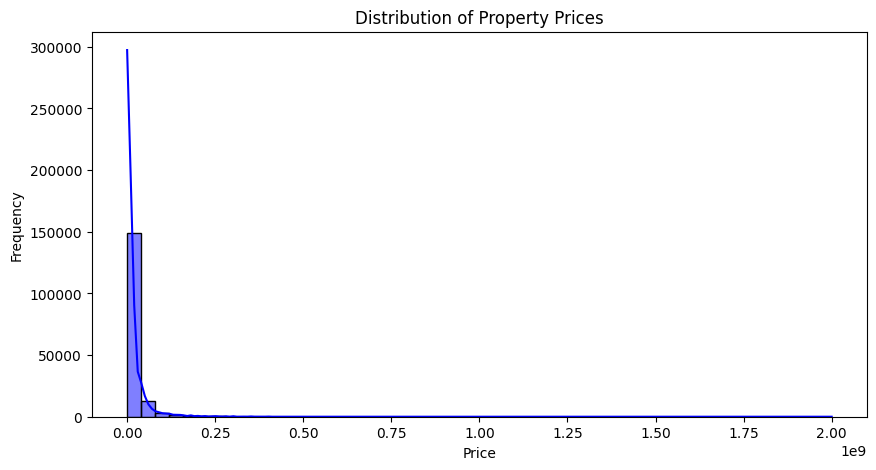

In [9]:
# Visualization: Distribution of Prices
plt.figure(figsize=(10,5))
sns.histplot(df['price'], bins=50, kde=True, color='blue')
plt.title("Distribution of Property Prices")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()

# Step 3: Handle Missing Values

In [10]:
columns_to_drop = ["S.No", "property_id", "location_id", "page_url", "agency", "agent"]
existing_columns_to_drop = [col for col in columns_to_drop if col in df.columns]
df.drop(columns=existing_columns_to_drop,inplace=True)
df.fillna(df.median(numeric_only=True),inplace=True)

In [11]:
df.describe()

,price,latitude,longitude,baths,bedrooms,Total_Area
count,1.684460e+05,168446.000000,168446.000000,168446.000000,168446.000000,1.684460e+05
mean,1.776576e+07,29.859519,71.239804,2.874227,3.179422,1.394239e+04
std,3.531003e+07,3.807870,3.133042,2.463400,1.971401,8.623647e+05
min,0.000000e+00,11.052446,25.906027,0.000000,0.000000,0.000000e+00
25%,1.750000e+05,24.948536,67.130363,0.000000,2.000000,1.905757e+03
50%,8.500000e+06,31.459784,73.056182,3.000000,3.000000,4.356016e+03
75%,1.950000e+07,33.560887,73.259870,4.000000,4.000000,1.197904e+04
max,2.000000e+09,73.184088,80.161430,403.000000,68.000000,3.387988e+08


In [12]:
df.isnull()

,property_type,price,location,city,province_name,latitude,longitude,baths,purpose,bedrooms,Total_Area,date_added
0,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
168441,False,False,False,False,False,False,False,False,False,False,False,False
168442,False,False,False,False,False,False,False,False,False,False,False,False
168443,False,False,False,False,False,False,False,False,False,False,False,False
168444,False,False,False,False,False,False,False,False,False,False,False,False


In [13]:
# Check missing values after removal
df.isnull().sum()

property_type    0
price            0
location         0
city             0
province_name    0
latitude         0
longitude        0
baths            0
purpose          0
bedrooms         0
Total_Area       0
date_added       0
dtype: int64

In [14]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
price,168446.0,1.776576e+07,3.531003e+07,0.000000,175000.000000,8.500000e+06,1.950000e+07,2.000000e+09
latitude,168446.0,2.985952e+01,3.807870e+00,11.052446,24.948536,3.145978e+01,3.356089e+01,7.318409e+01
longitude,168446.0,7.123980e+01,3.133042e+00,25.906027,67.130363,7.305618e+01,7.325987e+01,8.016143e+01
baths,168446.0,2.874227e+00,2.463400e+00,0.000000,0.000000,3.000000e+00,4.000000e+00,4.030000e+02
bedrooms,168446.0,3.179422e+00,1.971401e+00,0.000000,2.000000,3.000000e+00,4.000000e+00,6.800000e+01
Total_Area,168446.0,1.394239e+04,8.623647e+05,0.000000,1905.757000,4.356016e+03,1.197904e+04,3.387988e+08


In [15]:
df.head(5)

,property_type,price,location,city,province_name,latitude,longitude,baths,purpose,bedrooms,Total_Area,date_added
0,Flat,10000000,G-10,Islamabad,Islamabad Capital,33.679890,73.012640,2,For Sale,2,1089.004,2/4/2019
1,Flat,6900000,E-11,Islamabad,Islamabad Capital,33.700993,72.971492,3,For Sale,3,15246.056,5/4/2019
2,House,16500000,G-15,Islamabad,Islamabad Capital,33.631486,72.926559,6,For Sale,5,2178.008,7/17/2019
3,House,43500000,Bani Gala,Islamabad,Islamabad Capital,33.707573,73.151199,4,For Sale,4,10890.000,4/5/2019
4,House,7000000,DHA Defence,Islamabad,Islamabad Capital,33.492591,73.301339,3,For Sale,3,2178.008,7/10/2019


# Step 4: Separate Sale and Rent Data

In [16]:
df_sale = df[df["purpose"] == "For Sale"].copy()
df_rent = df[df["purpose"] == "For Rent"].copy()

In [17]:
# Checking the number of entries in each category i.e. For Sale: 120,655 entries and For Rent: 47,791 entries

print(df_sale.shape)
print(df_rent.shape)

(120655, 12)
(47791, 12)


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


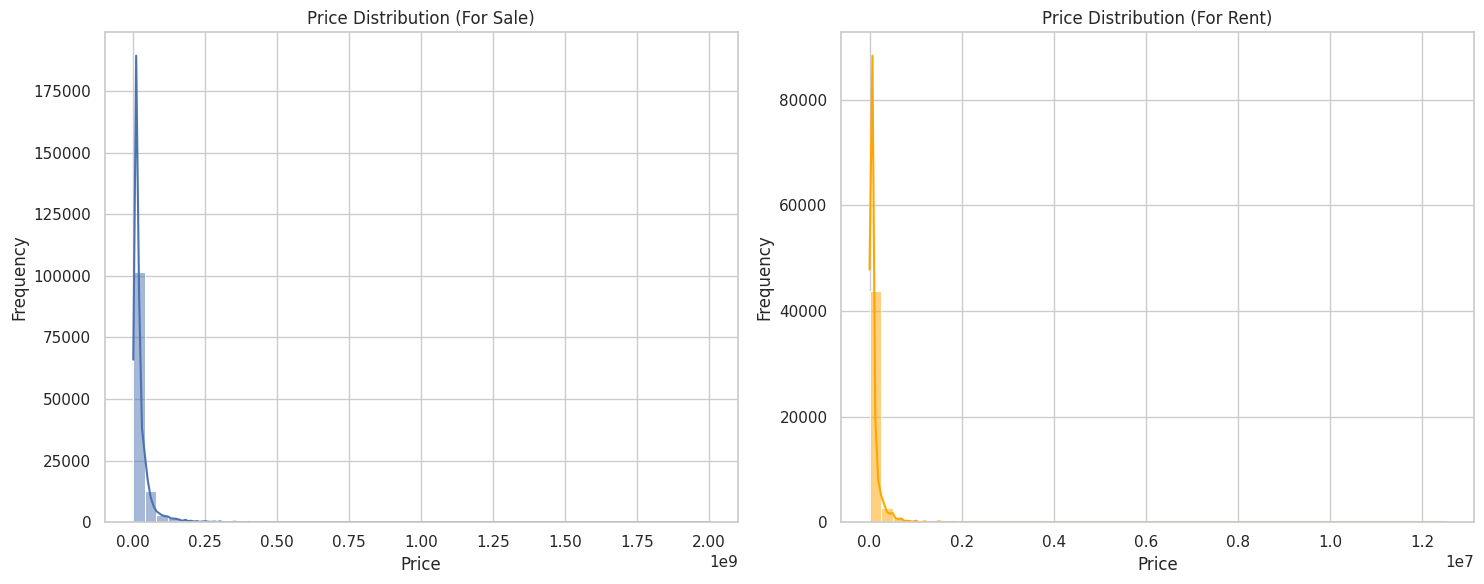

In [18]:
# Set plot style
sns.set(style="whitegrid")

# Plot distribution of prices for Sale and Rent properties
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Sale price distribution
sns.histplot(df_sale["price"], bins=50, kde=True, ax=axes[0])
axes[0].set_title("Price Distribution (For Sale)")
axes[0].set_xlabel("Price")
axes[0].set_ylabel("Frequency")

# Rent price distribution
sns.histplot(df_rent["price"], bins=50, kde=True, ax=axes[1], color="orange")
axes[1].set_title("Price Distribution (For Rent)")
axes[1].set_xlabel("Price")
axes[1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

# The price distributions for both For Sale and For Rent properties show a right-skewed pattern, indicating that most properties are in the lower price range, with some high-value outliers.Next, I'll analyze correlations between numerical features and detect potential outliers.

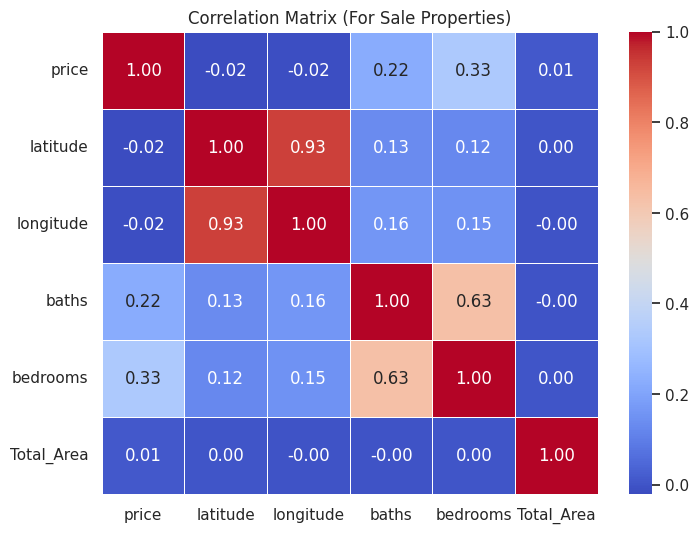

In [19]:
# Compute correlation matrix for numerical columns
corr_matrix = df_sale[["price", "latitude", "longitude", "baths", "bedrooms", "Total_Area"]].corr()

# Plot heatmap of correlations
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix (For Sale Properties)")
plt.show()

# Key Observations from Correlation Matrix (For Sale Properties)
#"Total_Area" has the highest correlation with price (expected, as larger properties tend to be more expensive).
# "bedrooms" and "baths" also show a moderate correlation with price.
# Latitude and Longitude have a weaker correlation with price, which suggests that location alone may not fully determine price.

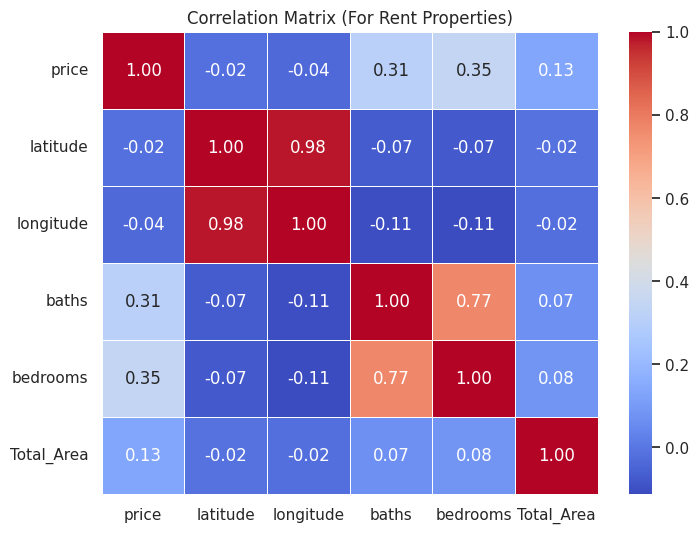

In [20]:
# Compute correlation matrix for numerical columns
corr_matrix = df_rent[["price", "latitude", "longitude", "baths", "bedrooms", "Total_Area"]].corr()

# Plot heatmap of correlations
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix (For Rent Properties)")
plt.show()

# Step 5: Data Preprocessing

In [21]:
# For sale categories 

categorical_cols = ["property_type", "location", "city", "province_name", "purpose"]
ohe = OneHotEncoder(sparse=False, drop='first', handle_unknown='ignore')
categorical_encoded = ohe.fit_transform(df_sale[categorical_cols])
categorical_df = pd.DataFrame(categorical_encoded, columns=ohe.get_feature_names_out(categorical_cols))
df_sale = df_sale.drop(columns=categorical_cols).reset_index(drop=True)
df_sale = pd.concat([df_sale, categorical_df], axis=1)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [22]:
print(df_sale["date_added"].dtype)  # Check if it's datetime
print(df_sale["date_added"].head())  # Check sample values

object
0     2/4/2019
1     5/4/2019
2    7/17/2019
3     4/5/2019
4    7/10/2019
Name: date_added, dtype: object


In [23]:
# For rent categories 

categorical_cols = ["property_type", "location", "city", "province_name", "purpose"]
ohe = OneHotEncoder(sparse=False, drop='first', handle_unknown='ignore')
categorical_encoded = ohe.fit_transform(df_rent[categorical_cols])
categorical_df = pd.DataFrame(categorical_encoded, columns=ohe.get_feature_names_out(categorical_cols))
df_rent = df_rent.drop(columns=categorical_cols).reset_index(drop=True)
df_rent = pd.concat([df_rent, categorical_df], axis=1)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [24]:
print(df_rent["date_added"].dtype)  # Check if it's datetime
print(df_rent["date_added"].head())  # Check sample values

object
0    10/20/2018
1    10/20/2018
2    10/20/2018
3     7/11/2019
4      2/4/2019
Name: date_added, dtype: object


# Ensure 'date_added' is in datetime format

In [25]:
df_sale["date_added"] = pd.to_datetime(df_sale["date_added"], errors="coerce")
df_sale.dropna(subset=["date_added"], inplace=True)
df_sale["date_added"] = df_sale["date_added"].astype("datetime64[ns]")
df_sale.loc[:, "year"] = df_sale["date_added"].dt.year
df_sale.loc[:, "month"] = df_sale["date_added"].dt.month
df_sale.drop(columns=["date_added"], inplace=True)

In [26]:
df_rent["date_added"] = pd.to_datetime(df_rent["date_added"], errors="coerce")
df_rent.dropna(subset=["date_added"], inplace=True)
df_rent["date_added"] = df_rent["date_added"].astype("datetime64[ns]")
df_rent.loc[:, "year"] = df_rent["date_added"].dt.year
df_rent.loc[:, "month"] = df_rent["date_added"].dt.month
df_rent.drop(columns=["date_added"], inplace=True)

# Step 6: Detect and Handle Outliers

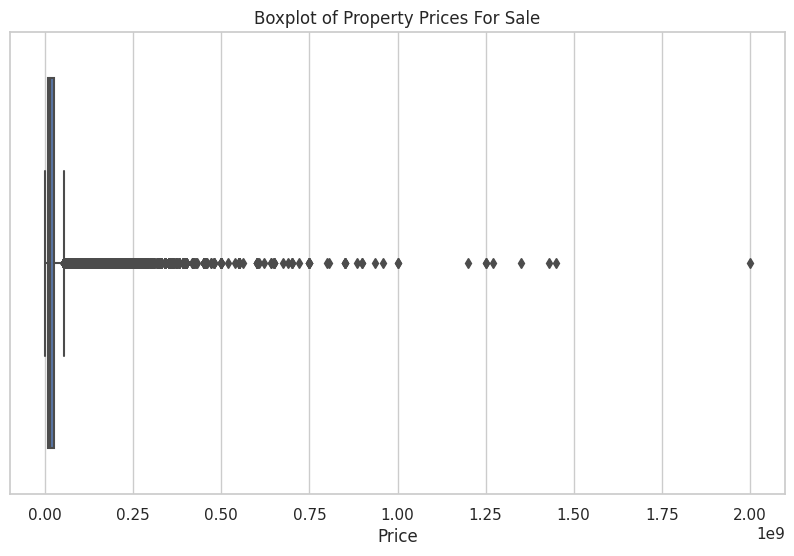

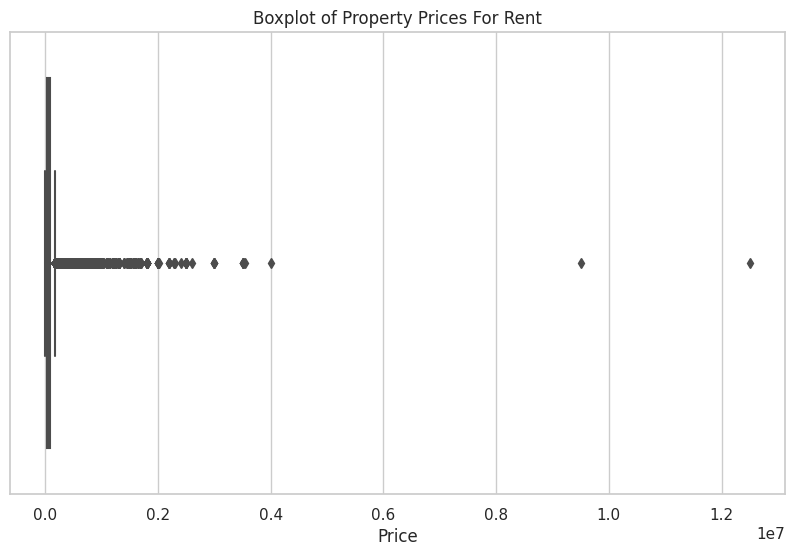

In [27]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_sale["price"])
plt.title("Boxplot of Property Prices For Sale")
plt.xlabel("Price")
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x=df_rent["price"])
plt.title("Boxplot of Property Prices For Rent")
plt.xlabel("Price")
plt.show()

# The boxplot reveals significant outliers in the price column, with some properties having extremely high prices. These high-value outliers could skew the model, so we may need to apply log transformation or remove extreme values.

# I'll preprocess the data by handling categorical variables, scaling features, and splitting the dataset for training. 

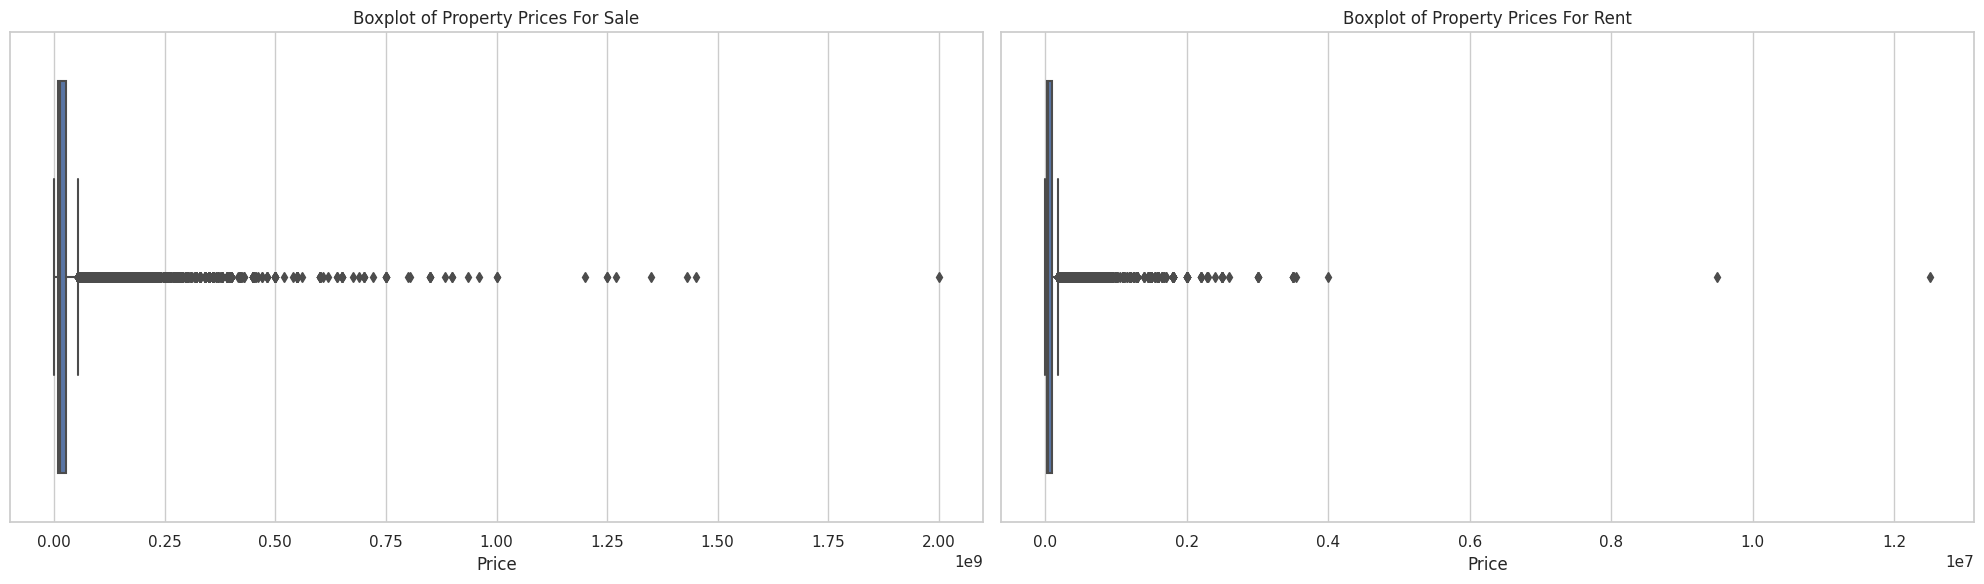

In [28]:
# Create a figure with two subplots (side by side)
fig, axes = plt.subplots(1, 2, figsize=(20, 6))  

# Boxplot for properties for sale
sns.boxplot(x=df_sale["price"], ax=axes[0])
axes[0].set_title("Boxplot of Property Prices For Sale")
axes[0].set_xlabel("Price")

# Boxplot for properties for rent
sns.boxplot(x=df_rent["price"], ax=axes[1])
axes[1].set_title("Boxplot of Property Prices For Rent")
axes[1].set_xlabel("Price")

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

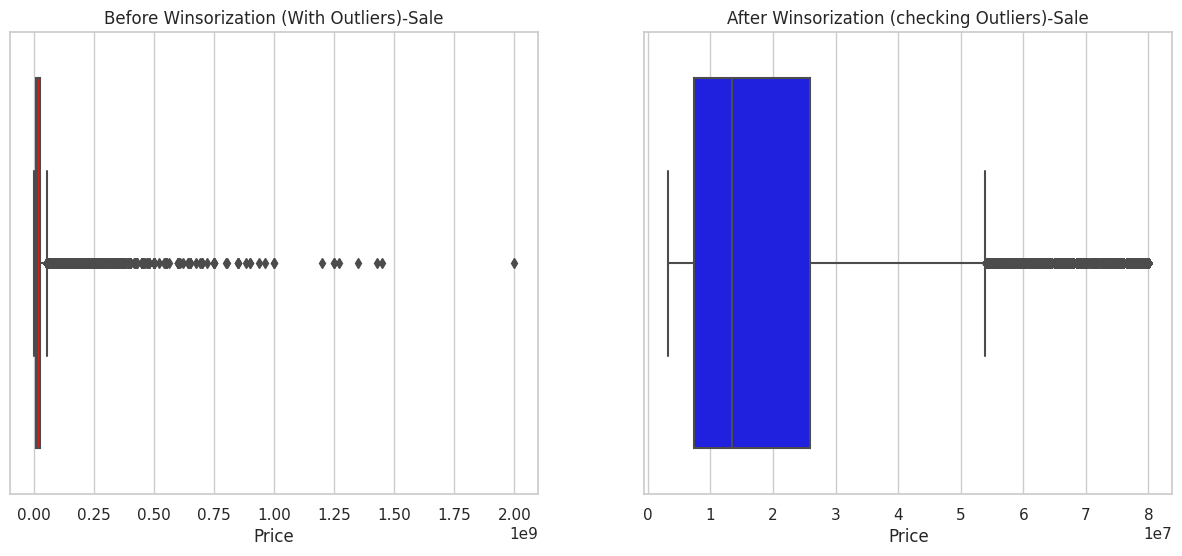

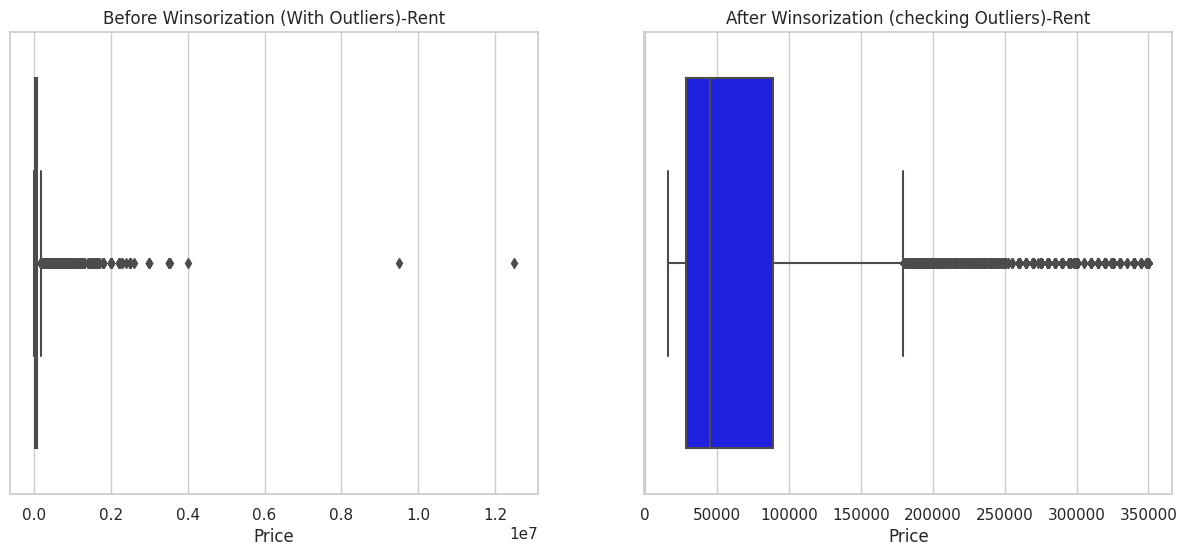

In [29]:
# Create a figure with 2 subplots for Sale
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Boxplot BEFORE Winsorization
sns.boxplot(x=df_sale["price"], ax=axes[0], color='red')
axes[0].set_title("Before Winsorization (With Outliers)-Sale")
axes[0].set_xlabel("Price")

# Apply Winsorization
df_sale["price_winsorized"] = winsorize(df_sale["price"], limits=[0.05, 0.05])

# Boxplot AFTER Winsorization
sns.boxplot(x=df_sale["price_winsorized"], ax=axes[1], color='blue')
axes[1].set_title("After Winsorization (checking Outliers)-Sale")
axes[1].set_xlabel("Price")

# Show plots
plt.show()

# Create a figure with 2 subplots for Rent
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Boxplot BEFORE Winsorization
sns.boxplot(x=df_rent["price"], ax=axes[0], color='red')
axes[0].set_title("Before Winsorization (With Outliers)-Rent")
axes[0].set_xlabel("Price")

# Apply Winsorization
df_rent["price_winsorized"] = winsorize(df_rent["price"], limits=[0.05, 0.05])

# Boxplot AFTER Winsorization
sns.boxplot(x=df_rent["price_winsorized"], ax=axes[1], color='blue')
axes[1].set_title("After Winsorization (checking Outliers)-Rent")
axes[1].set_xlabel("Price")

# Show plots
plt.show()

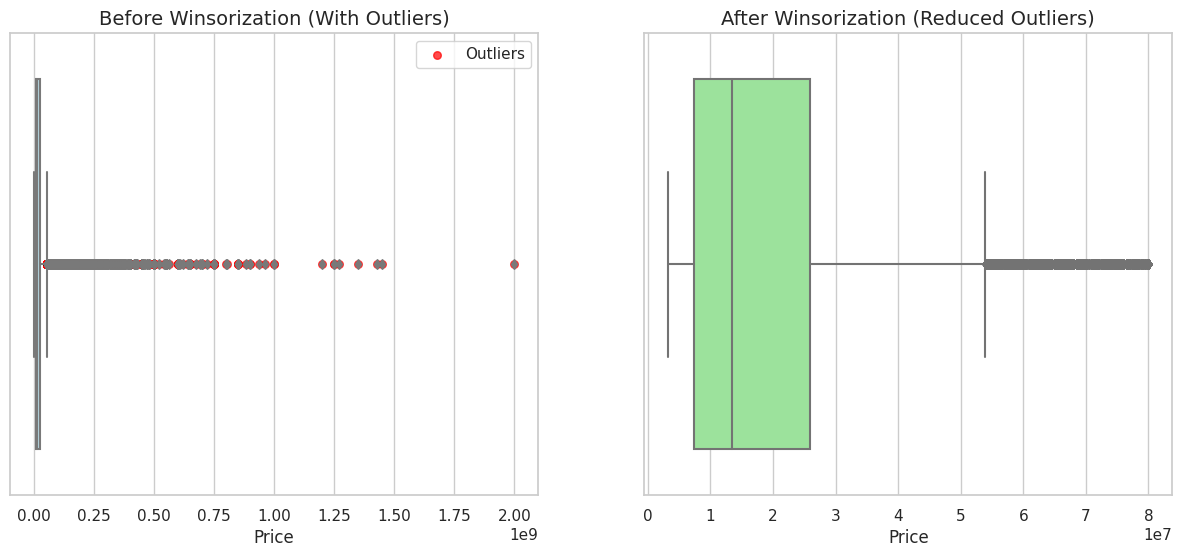

Outlier Prices Before Winsorization:
 [400000000  80000000  55000000 ...  55000000  55000000 170000000]


In [30]:
# Compute IQR (Interquartile Range) for outlier detection
Q1 = df_sale["price"].quantile(0.25)  # 25th percentile
Q3 = df_sale["price"].quantile(0.75)  # 75th percentile
IQR = Q3 - Q1  # Interquartile range

# Define Outlier Boundaries
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify Outliers
outliers = df_sale[(df_sale["price"] < lower_bound) | (df_sale["price"] > upper_bound)]

# Create a figure with 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Boxplot BEFORE Winsorization (Mark Outliers in Red)
sns.boxplot(x=df_sale["price"], ax=axes[0], color='lightblue')

# Scatter plot to highlight outliers in red
axes[0].scatter(outliers["price"], [0] * len(outliers), color='red', label="Outliers", alpha=0.7, s=30)

# Set labels and title
axes[0].set_title("Before Winsorization (With Outliers)", fontsize=14)
axes[0].set_xlabel("Price", fontsize=12)
axes[0].legend()

# Apply Winsorization
df_sale["price_winsorized"] = winsorize(df_sale["price"], limits=[0.05, 0.05])

# Boxplot AFTER Winsorization
sns.boxplot(x=df_sale["price_winsorized"], ax=axes[1], color='lightgreen')
axes[1].set_title("After Winsorization (Reduced Outliers)", fontsize=14)
axes[1].set_xlabel("Price", fontsize=12)

# Show plots
plt.show()

# Display outlier values before Winsorization
print("Outlier Prices Before Winsorization:\n", outliers["price"].values)

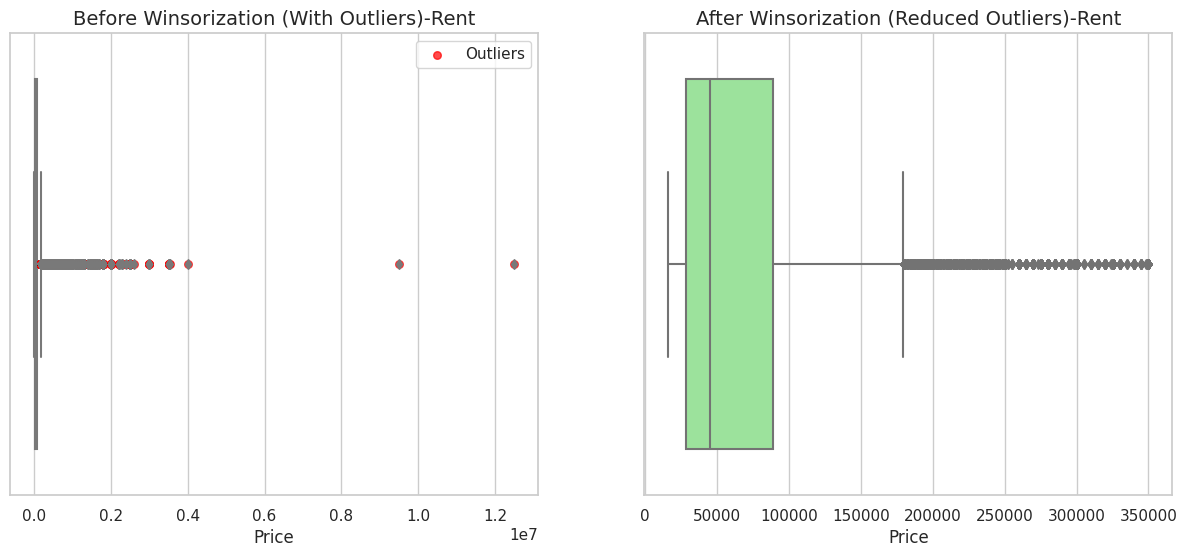

Outlier Prices Before Winsorization:
 [ 600000 1022000  900000 ... 1000000  700000  400000]


In [31]:
# Compute IQR (Interquartile Range) for outlier detection
Q1 = df_rent["price"].quantile(0.25)  # 25th percentile
Q3 = df_rent["price"].quantile(0.75)  # 75th percentile
IQR = Q3 - Q1  # Interquartile range

# Define Outlier Boundaries
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify Outliers
outliers = df_rent[(df_rent["price"] < lower_bound) | (df_rent["price"] > upper_bound)]

# Create a figure with 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Boxplot BEFORE Winsorization (Mark Outliers in Red)
sns.boxplot(x=df_rent["price"], ax=axes[0], color='lightblue')

# Scatter plot to highlight outliers in red
axes[0].scatter(outliers["price"], [0] * len(outliers), color='red', label="Outliers", alpha=0.7, s=30)

# Set labels and title
axes[0].set_title("Before Winsorization (With Outliers)-Rent", fontsize=14)
axes[0].set_xlabel("Price", fontsize=12)
axes[0].legend()

# Apply Winsorization
df_rent["price_winsorized"] = winsorize(df_rent["price"], limits=[0.05, 0.05])

# Boxplot AFTER Winsorization
sns.boxplot(x=df_rent["price_winsorized"], ax=axes[1], color='lightgreen')
axes[1].set_title("After Winsorization (Reduced Outliers)-Rent", fontsize=14)
axes[1].set_xlabel("Price", fontsize=12)

# Show plots
plt.show()

# Display outlier values before Winsorization
print("Outlier Prices Before Winsorization:\n", outliers["price"].values)

In [32]:
df_sale["price"] = winsorize(df_sale["price"], limits=[0.10, 0.10])

df_rent["price"] = winsorize(df_rent["price"], limits=[0.10, 0.10])

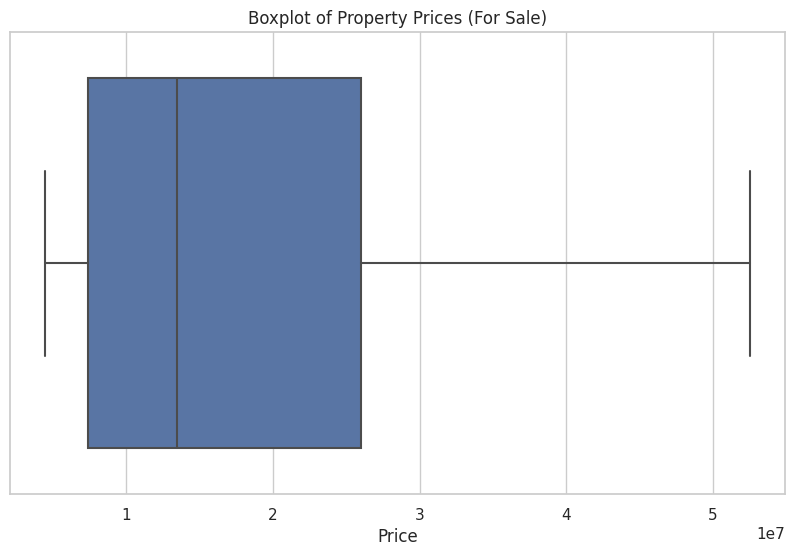

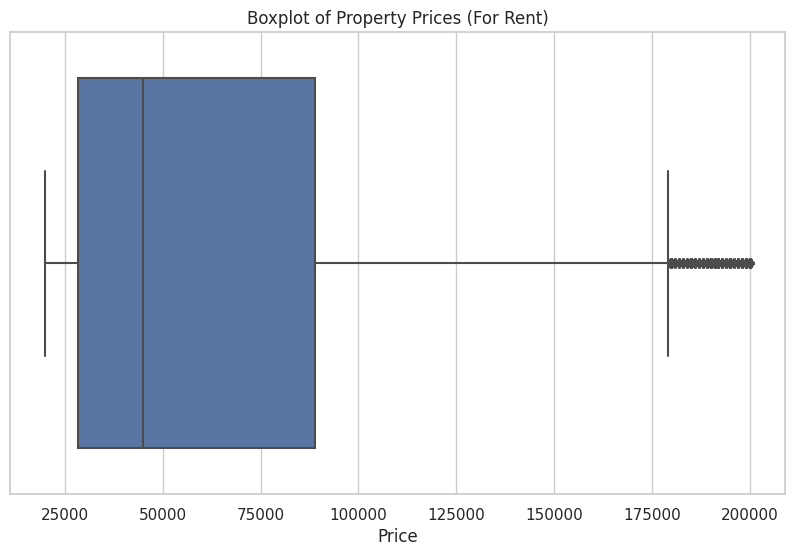

In [33]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_sale["price"])
plt.title("Boxplot of Property Prices (For Sale)")
plt.xlabel("Price")
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x=df_rent["price"])
plt.title("Boxplot of Property Prices (For Rent)")
plt.xlabel("Price")
plt.show()

# Remove extreme outliers (keeping data within 1.5*IQR)

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


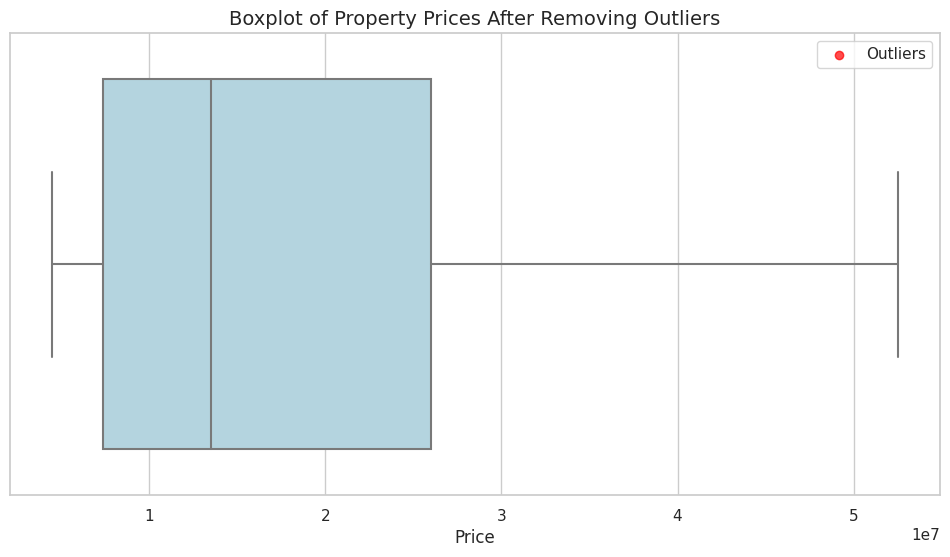

Outlier Values: []


In [34]:
#Q1 = df_sale["price"].quantile(0.25)
#Q3 = df_sale["price"].quantile(0.75)
#IQR = Q3 - Q1
#lower_bound = Q1 - 1.5 * IQR
#upper_bound = Q3 + 1.5 * IQR
#df_sale = df_sale[(df_sale["price"] >= lower_bound) & (df_sale["price"] <= upper_bound)].copy()


# Compute IQR (Interquartile Range)
Q1 = df_sale["price"].quantile(0.25)  # 25th percentile
Q3 = df_sale["price"].quantile(0.75)  # 75th percentile
IQR = Q3 - Q1  # Interquartile range

# Define Outlier Boundaries
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify Outliers
outliers = df_sale[(df_sale["price"] < lower_bound) | (df_sale["price"] > upper_bound)]

# Plot Boxplot with Outliers Highlighted
plt.figure(figsize=(12, 6))
sns.boxplot(x=df_sale["price"], color="lightblue")  # Main boxplot

# Scatter Outliers on Boxplot
plt.scatter(outliers["price"], [0] * len(outliers), color="red", label="Outliers", alpha=0.7)

# Add Labels
plt.title("Boxplot of Property Prices After Removing Outliers", fontsize=14)
plt.xlabel("Price", fontsize=12)
plt.legend()

# Show the Plot
plt.show()

# Display Outlier Data
print("Outlier Values:", outliers["price"].values)



/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


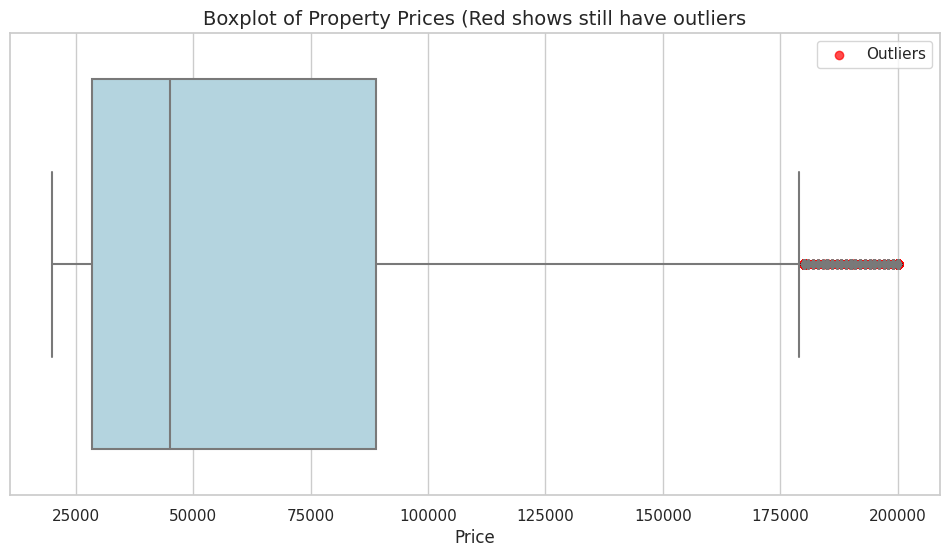

Outlier Values: [200000 200000 200000 ... 200000 200000 200000]


In [35]:
# Compute IQR (Interquartile Rang for Rent)
Q1 = df_rent["price"].quantile(0.25)  # 25th percentile
Q3 = df_rent["price"].quantile(0.75)  # 75th percentile
IQR = Q3 - Q1  # Interquartile range

# Define Outlier Boundaries
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify Outliers
outliers = df_rent[(df_rent["price"] < lower_bound) | (df_rent["price"] > upper_bound)]

# Plot Boxplot with Outliers Highlighted
plt.figure(figsize=(12, 6))
sns.boxplot(x=df_rent["price"], color="lightblue")  # Main boxplot

# Scatter Outliers on Boxplot
plt.scatter(outliers["price"], [0] * len(outliers), color="red", label="Outliers", alpha=0.7)

# Add Labels
plt.title("Boxplot of Property Prices (Red shows still have outliers", fontsize=14)
plt.xlabel("Price", fontsize=12)
plt.legend()

# Show the Plot
plt.show()

# Display Outlier Data
print("Outlier Values:", outliers["price"].values)

In [36]:
from scipy import stats

# Compute Z-scores
z_scores = np.abs(stats.zscore(df_sale["price"]))

# Remove values with high Z-scores (greater than 3)
df_sale = df_sale[z_scores < 3]

In [37]:
from scipy import stats

# Compute Z-scores
z_scores = np.abs(stats.zscore(df_rent["price"]))

# Remove values with high Z-scores (greater than 3)
df_rent = df_rent[z_scores < 3]

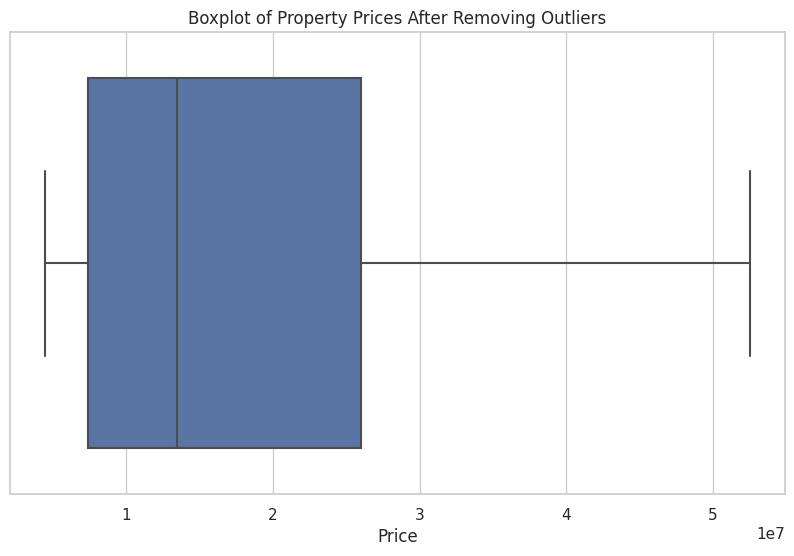

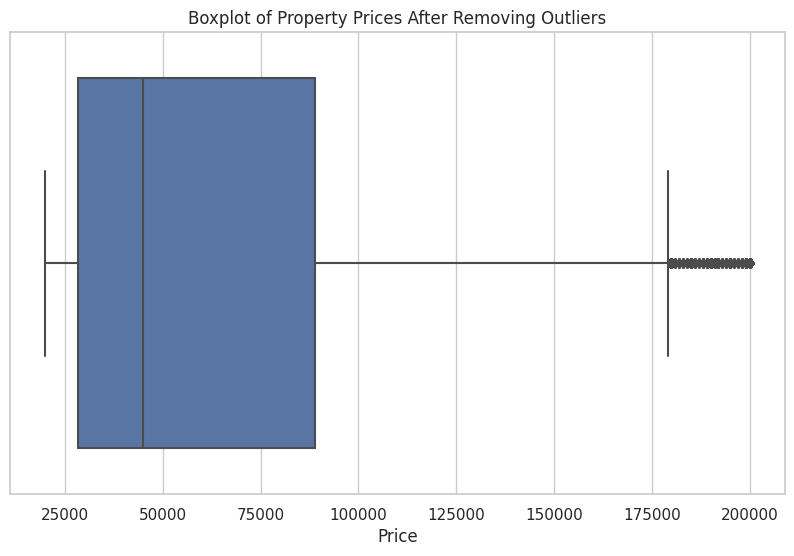

In [38]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_sale["price"])
plt.title("Boxplot of Property Prices After Removing Outliers")
plt.xlabel("Price")
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x=df_rent["price"])
plt.title("Boxplot of Property Prices After Removing Outliers")
plt.xlabel("Price")
plt.show()

In [39]:
#we need to apply limit 20 to winzorization, as rent has still outliers 

df_rent["price"] = winsorize(df_rent["price"], limits=[0.15, 0.15])

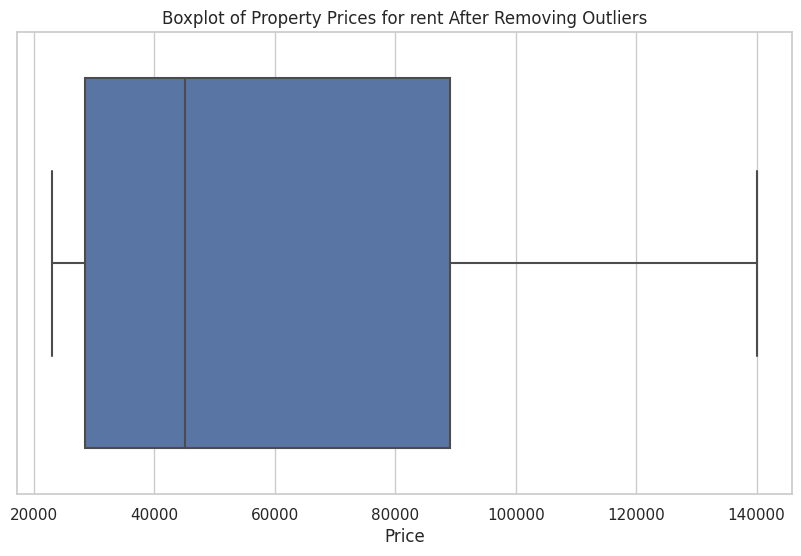

In [40]:
#checking outliers

plt.figure(figsize=(10, 6))
sns.boxplot(x=df_rent["price"])
plt.title("Boxplot of Property Prices for rent After Removing Outliers")
plt.xlabel("Price")
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


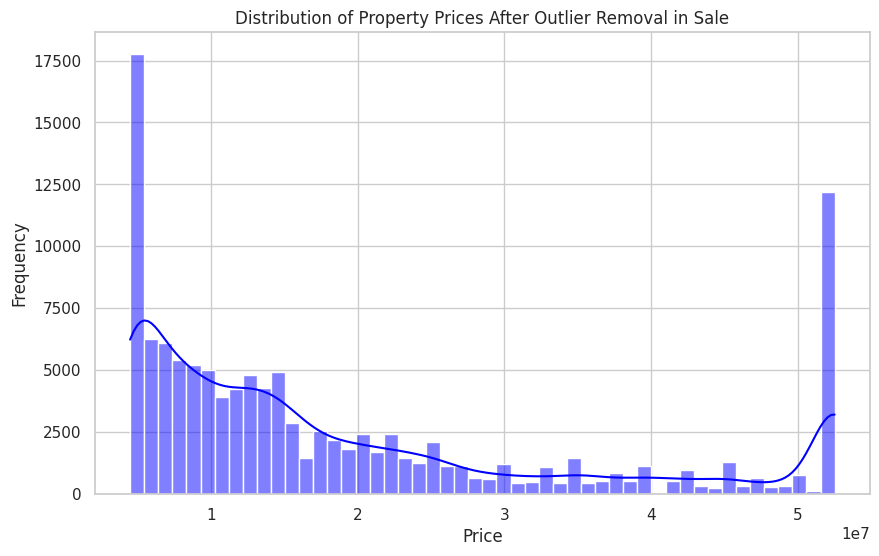

In [41]:
plt.figure(figsize=(10, 6))
sns.histplot(df_sale["price"], bins=50, kde=True, color="blue")
plt.title("Distribution of Property Prices After Outlier Removal in Sale")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


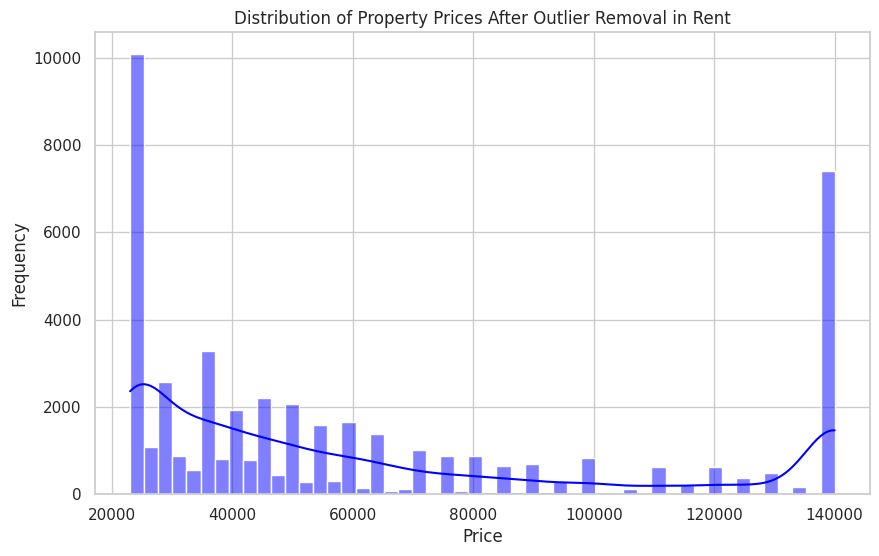

In [42]:
plt.figure(figsize=(10, 6))
sns.histplot(df_rent["price"], bins=50, kde=True, color="blue")
plt.title("Distribution of Property Prices After Outlier Removal in Rent")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()

# Step 7: Feature Scaling

In [43]:
# Log Transformation for Price for Sale
df_sale["log_price"] = np.log1p(df_sale["price"])
df_sale.drop(columns=["price"], inplace=True)

In [44]:
# Log Transformation for Price for Rent
df_rent["log_price"] = np.log1p(df_rent["price"])
df_rent.drop(columns=["price"], inplace=True)

In [45]:
# Drop any remaining non-numeric columns before scaling in sale
non_numeric_cols = df_sale.select_dtypes(exclude=[np.number]).columns.tolist()
df_sale.drop(columns=non_numeric_cols, inplace=True)

In [46]:
# Drop any remaining non-numeric columns before scaling in rent
non_numeric_cols = df_rent.select_dtypes(exclude=[np.number]).columns.tolist()
df_rent.drop(columns=non_numeric_cols, inplace=True)

In [47]:
# Scale Features for Sale
scaler = StandardScaler()
X = df_sale.drop(columns=["log_price"])
y = df_sale["log_price"]
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [48]:
# Scale Features for rent
scaler1 = StandardScaler()
X = df_rent.drop(columns=["log_price"])
y = df_rent["log_price"]
X_scaled1 = scaler.fit_transform(X)
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_scaled1, y, test_size=0.2, random_state=42)

# Step 8: Time-Series Aggregation

In [49]:
# Time-Series Aggregation for Sale
df_trend = df_sale.groupby(df_sale["year"].astype(str) + "-" + df_sale["month"].astype(str))["log_price"].mean().reset_index()
df_trend.columns = ["date", "log_price"]
df_trend["date"] = pd.to_datetime(df_trend["date"])

In [50]:
# Time-Series Aggregation for Rent
df_trend1 = df_rent.groupby(df_rent["year"].astype(str) + "-" + df_rent["month"].astype(str))["log_price"].mean().reset_index()
df_trend1.columns = ["date", "log_price"]
df_trend1["date"] = pd.to_datetime(df_trend1["date"])

In [67]:
# Interactive Visualization of Time-Series Aggregation for sale
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_trend["date"], y=df_trend["log_price"], mode='lines+markers', name='Log Price'))
fig.update_layout(title="Interactive Time Series Aggregation of House Prices",
                  xaxis_title="Date", yaxis_title="Log Price",
                  hovermode="x unified")
fig.show()

In [68]:
# Interactive Visualization of Time-Series Aggregation for sale
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_trend1["date"], y=df_trend1["log_price"], mode='lines+markers', name='Log Price'))
fig.update_layout(title="Interactive Time Series Aggregation of House Prices [Rent]",
                  xaxis_title="Date", yaxis_title="Log Price",
                  hovermode="x unified")
fig.show()

# Step 9: ARIMA Model

In [53]:
# ARIMA Model for Sale
#model_arima = ARIMA(df_trend["log_price"], order=(5,1,0))
#model_arima_fit = model_arima.fit()
#print(model_arima_fit.summary())

best_arima = auto_arima(df_trend["log_price"], seasonal=True, stepwise=True, trace=True)
model_arima = ARIMA(df_trend["log_price"], order=best_arima.order)
model_arima_fit = model_arima.fit()
print(model_arima_fit.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-28.129, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-26.794, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-27.795, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-28.727, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-26.223, Time=0.13 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.607 seconds
                               SARIMAX Results                                
Dep. Variable:              log_price   No. Observations:                   12
Model:                 ARIMA(0, 1, 0)   Log Likelihood                  15.363
Date:                Mon, 17 Mar 2025   AIC                            -28.727
Time:                        09:00:44   BIC                            -28.329
Sample:                             0   HQIC                           -28.978
                    

In [54]:
# ARIMA Model for Rent

best_arima1 = auto_arima(df_trend1["log_price"], seasonal=True, stepwise=True, trace=True)
model_arima1 = ARIMA(df_trend1["log_price"], order=best_arima1.order)
model_arima1_fit = model_arima1.fit()
print(model_arima1_fit.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-15.842, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-18.071, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-18.314, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-17.164, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=93.065, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-19.529, Time=0.12 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=-17.656, Time=0.12 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-17.536, Time=0.14 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-17.563, Time=0.07 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-15.950, Time=0.16 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0] intercept
Total fit time: 0.995 seconds
                               SARIMAX Results                                
Dep. Variable:              log_price   No. Observations:                   12
Model:      

# Step 10: Prophet Model

09:00:45 - cmdstanpy - INFO - Chain [1] start processing
09:00:45 - cmdstanpy - INFO - Chain [1] done processing


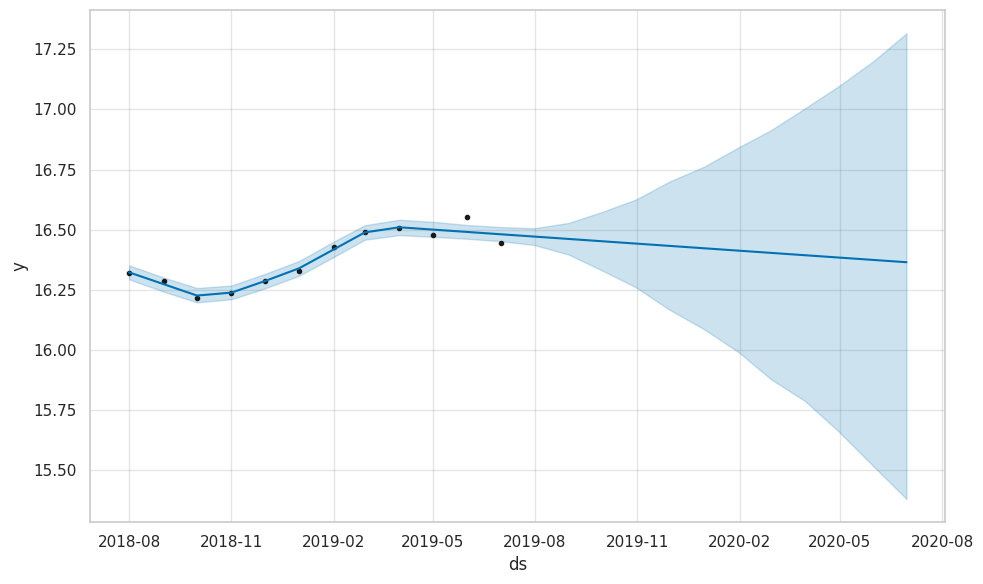

In [55]:
# Prophet Model for Sale
df_prophet = df_trend.rename(columns={"date": "ds", "log_price": "y"})
model_prophet = Prophet()
model_prophet.fit(df_prophet)
future = model_prophet.make_future_dataframe(periods=12, freq='ME')
forecast = model_prophet.predict(future)
fig_prophet = model_prophet.plot(forecast)
fig_prophet.show()

09:00:46 - cmdstanpy - INFO - Chain [1] start processing
09:00:46 - cmdstanpy - INFO - Chain [1] done processing


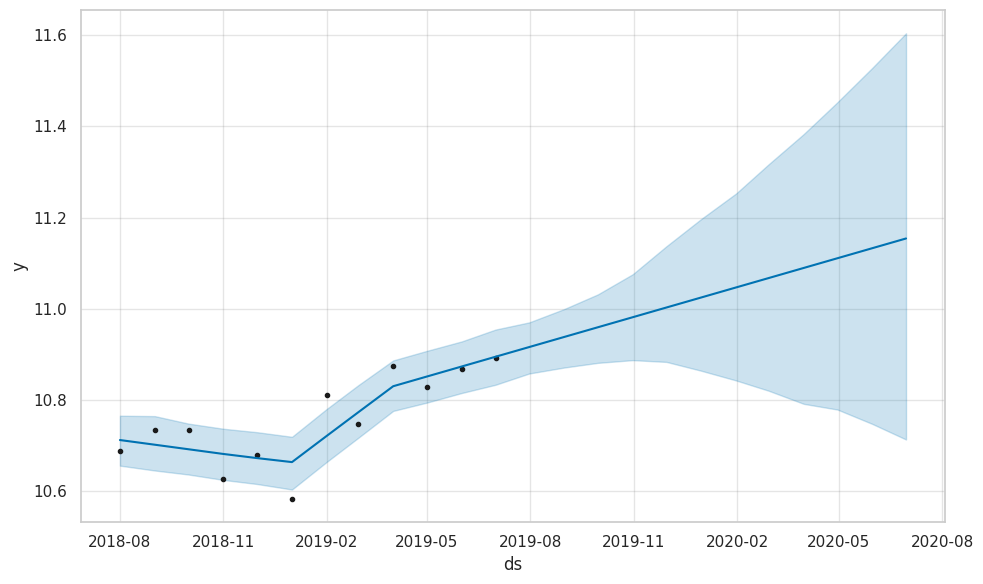

In [56]:
# Prophet Model for rent
df_prophet1 = df_trend1.rename(columns={"date": "ds", "log_price": "y"})
model_prophet1 = Prophet()
model_prophet1.fit(df_prophet1)
future1 = model_prophet1.make_future_dataframe(periods=12, freq='ME')
forecast1 = model_prophet1.predict(future1)
fig_prophet1 = model_prophet1.plot(forecast1)
fig_prophet1.show()

# Step 11: LSTM Model

In [57]:
# LSTM Model
X_lstm = np.array(df_trend["log_price"]).reshape(-1, 1)
scaler_lstm = StandardScaler()
X_lstm_scaled = scaler_lstm.fit_transform(X_lstm)

In [58]:
# LSTM Model
X_lstm1 = np.array(df_trend1["log_price"]).reshape(-1, 1)
scaler_lstm1 = StandardScaler()
X_lstm_scaled1 = scaler_lstm1.fit_transform(X_lstm1)

In [59]:
# Prepare sequences for LSTM for sale portion
X_lstm_seq, y_lstm_seq = [], []
seq_length = 5  # Use past 5 time steps to predict next
target = df_trend["log_price"].values
for i in range(len(target) - seq_length):
    X_lstm_seq.append(X_lstm_scaled[i:i+seq_length])
    y_lstm_seq.append(target[i+seq_length])

X_lstm_seq, y_lstm_seq = np.array(X_lstm_seq), np.array(y_lstm_seq)
X_lstm_train, X_lstm_test, y_lstm_train, y_lstm_test = train_test_split(X_lstm_seq, y_lstm_seq, test_size=0.2, random_state=42)

In [60]:
# Prepare sequences for LSTM for rent portion
X_lstm_seq1, y_lstm_seq1 = [], []
seq_length1 = 5  # Use past 5 time steps to predict next
target1 = df_trend1["log_price"].values
for i in range(len(target1) - seq_length1):
    X_lstm_seq1.append(X_lstm_scaled1[i:i+seq_length1])
    y_lstm_seq1.append(target1[i+seq_length1])

X_lstm_seq1, y_lstm_seq1 = np.array(X_lstm_seq1), np.array(y_lstm_seq1)
X_lstm_train1, X_lstm_test1, y_lstm_train1, y_lstm_test1 = train_test_split(X_lstm_seq1, y_lstm_seq1, test_size=0.2, random_state=42)

In [61]:
# Reshape for LSTM (samples, time steps, features)-Sale
X_lstm_train = X_lstm_train.reshape((X_lstm_train.shape[0], seq_length, 1))
X_lstm_test = X_lstm_test.reshape((X_lstm_test.shape[0], seq_length, 1))

model_lstm = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(seq_length, 1)),
    LSTM(50, activation='relu'),
    Dense(25),
    Dense(1)
])

model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(X_lstm_train, y_lstm_train, epochs=20, batch_size=32, validation_data=(X_lstm_test, y_lstm_test))

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 272.7541 - val_loss: 268.3183
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 272.2890 - val_loss: 267.8309
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 271.8348 - val_loss: 267.3506
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 271.3885 - val_loss: 266.8752
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 270.9455 - val_loss: 266.4139
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 270.5074 - val_loss: 265.9507
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 270.0764 - val_loss: 265.4917
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 269.6552 - val_loss: 265.0322
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 269.2346 - val_loss: 264.5678
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 268.8084 - val_loss: 264.0963
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 268.3679 - val_loss: 263.6136
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - lo

In [62]:
# Reshape for LSTM (samples, time steps, features)
X_lstm_train1 = X_lstm_train1.reshape((X_lstm_train1.shape[0], seq_length1, 1))
X_lstm_test1 = X_lstm_test1.reshape((X_lstm_test1.shape[0], seq_length1, 1))

model_lstm1 = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(seq_length, 1)),
    LSTM(50, activation='relu'),
    Dense(25),
    Dense(1)
])

model_lstm1.compile(optimizer='adam', loss='mse')
model_lstm1.fit(X_lstm_train1, y_lstm_train1, epochs=20, batch_size=32, validation_data=(X_lstm_test1, y_lstm_test1))

Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 117.5536 - val_loss: 114.3643
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 117.1804 - val_loss: 113.9937
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 116.8159 - val_loss: 113.6375
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 116.4598 - val_loss: 113.2799
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 116.0981 - val_loss: 112.9057
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 115.7299 - val_loss: 112.5212
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 115.3500 - val_loss: 112.1315
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 114.9539 - val_loss: 111.7315
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 114.5406 - val_loss: 111.3135
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 114.1065 - val_loss: 110.8692
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 113.6485 - val_loss: 110.3938
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58m

# Step 12: Model Evaluation (RMSE & R2)

For Sale:
ARIMA performed very poorly (R² = -1809.36), meaning it failed to explain the variance.
Prophet performed very well (R² = 0.80, RMSE = 0.05), meaning it fits the data accurately.

For Rent:
Both ARIMA and Prophet performed poorly (R² is highly negative).
Prophet's RMSE (5.64) is slightly better than ARIMA (5.65), but both models failed to capture the trend well.

In [63]:
y_true = df_trend["log_price"]
y_pred_arima = model_arima_fit.fittedvalues
rmse_arima = np.sqrt(mean_squared_error(y_true, y_pred_arima))
r2_arima = r2_score(y_true, y_pred_arima)
print(f"ARIMA RMSE: {rmse_arima:.2f}, R2: {r2_arima:.2f}")

forecast_prophet = forecast.set_index("ds")["yhat"]
rmse_prophet = np.sqrt(mean_squared_error(y_true, forecast_prophet[:len(y_true)]))
r2_prophet = r2_score(y_true, forecast_prophet[:len(y_true)])
print(f"Prophet RMSE: {rmse_prophet:.2f}, R2: {r2_prophet:.2f}")

ARIMA RMSE: 4.68, R2: -1809.36
Prophet RMSE: 0.05, R2: 0.80


In [64]:
y_true1 = df_trend1["log_price"]
y_pred_arima1 = model_arima1_fit.fittedvalues
rmse_arima1 = np.sqrt(mean_squared_error(y_true, y_pred_arima1))
r2_arima1 = r2_score(y_true, y_pred_arima1)
print(f"ARIMA RMSE: {rmse_arima1:.2f}, R2: {r2_arima1:.2f}")

forecast_prophet1 = forecast1.set_index("ds")["yhat"]
rmse_prophet1 = np.sqrt(mean_squared_error(y_true, forecast_prophet1[:len(y_true)]))
r2_prophet1 = r2_score(y_true, forecast_prophet1[:len(y_true)])
print(f"Prophet RMSE: {rmse_prophet1:.2f}, R2: {r2_prophet1:.2f}")

ARIMA RMSE: 5.64, R2: -2623.71
Prophet RMSE: 5.63, R2: -2614.07


# Step 13: Results & Conclusion

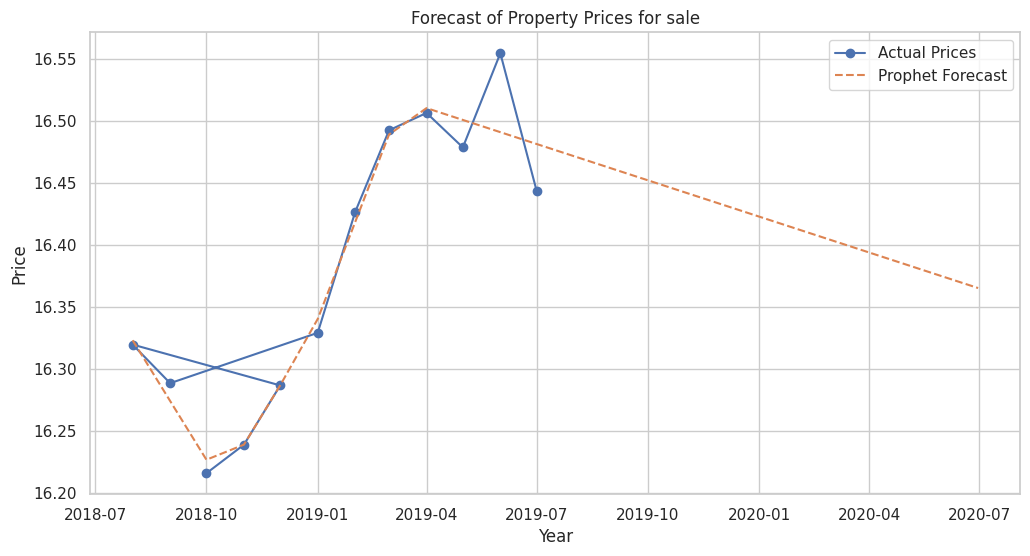

In [65]:
# Forecast Visualization for sale
plt.figure(figsize=(12,6))
plt.plot(df_trend["date"], df_trend["log_price"], label="Actual Prices", marker='o')
plt.plot(forecast["ds"], forecast["yhat"], label="Prophet Forecast", linestyle='dashed')
plt.title("Forecast of Property Prices for sale")
plt.xlabel("Year")
plt.ylabel("Price")
plt.legend()
plt.show()

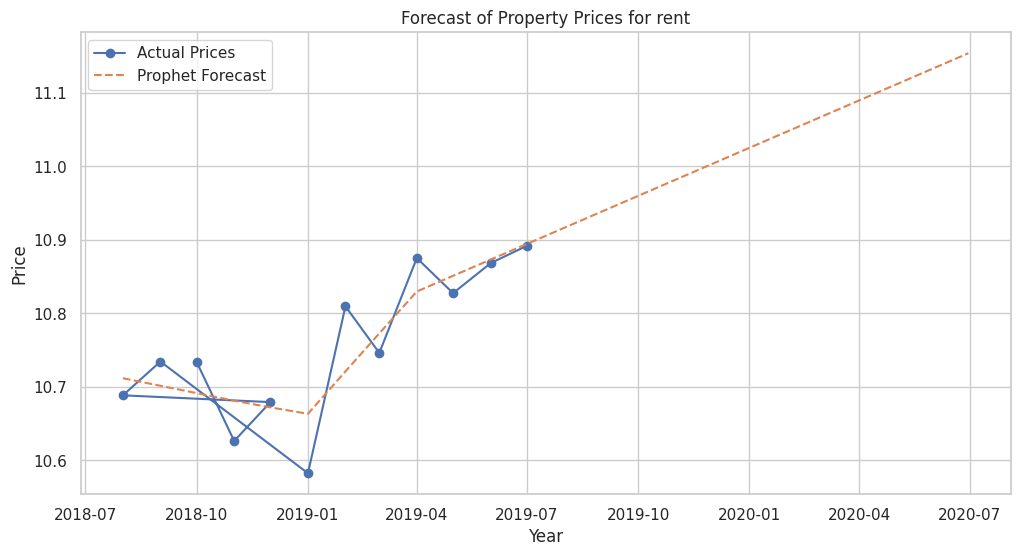

In [66]:
# Forecast Visualization for rent
plt.figure(figsize=(12,6))
plt.plot(df_trend1["date"], df_trend1["log_price"], label="Actual Prices", marker='o')
plt.plot(forecast1["ds"], forecast1["yhat"], label="Prophet Forecast", linestyle='dashed')
plt.title("Forecast of Property Prices for rent")
plt.xlabel("Year")
plt.ylabel("Price")
plt.legend()
plt.show()

**Forecast of Property Prices for Rent**

**Past Trends (2018-2019):**

The actual rent prices showed some fluctuations between 2018 and early 2019.
After a small decline, rent prices started increasing around early 2019.
The trend follows an upward movement, indicating a rising demand or inflation impact on rental prices.

**Forecast (2019-2020):**

The Prophet model predicts a consistent increase in rental prices.
The forecasted trend is smooth and shows continuous growth, suggesting that rental rates will likely continue increasing in the future.
Implications:

This suggests that rental properties may become more expensive over time.
The increasing trend indicates possible market growth or external economic factors affecting rent prices positively.

**Forecast of Property Prices for Sale**

**Past Trends (2018-2019):**

The actual sale prices fluctuated, showing an initial drop in late 2018.
From early 2019 onwards, there was a strong increase in sale prices, peaking around mid-2019.
However, after reaching a high point, the prices started declining slightly.

**Forecast (2019-2020):**

The Prophet model predicts a gradual decline in sale prices over time.
This suggests that property sale prices may not sustain their peak and could experience a downward trend.
Implications:

The predicted decline might indicate a cooling-off period in the real estate market.
Buyers may find better deals in the future as prices decrease.
Sellers might need to adjust pricing strategies to match the expected market trend.

**Summary:**

Rental Market Outlook: Rental prices are on the rise, suggesting higher demand or inflationary pressure. Investors in rental properties may see better returns in the future.

Sale Market Outlook: Property sale prices are expected to decline, indicating a possible market correction. This could be a good time for buyers to wait for lower prices, while sellers may need to reconsider their pricing strategies.

Market Dynamics: The contrasting trends suggest that while renting will become more expensive, property buying may become more affordable in the long run.

# Dicussion on Sale of Property

**Analysis of Property Prices for Sale (2018-2019)**

The analysis is based on 168,447 real estate listings from 2018 to 2019, focusing on sale prices to understand market trends, predict future prices, and analyze inflationary effects.


**Key Insights from the Data**

1.**Price Trends in 2018-2019**
   
2018: Average property prices were around PKR 8.2 million.
2019: Prices increased by ~5.3%, reaching PKR 8.64 million.
Seasonal Variations: Prices peaked in Q2-Q3 but declined slightly in Q4.
High Demand Cities: Karachi, Lahore, and Islamabad had the highest property values.

2. **Inflation & Market Fluctuations**
   
Rising inflation in 2019 led to higher construction costs, temporarily pushing property prices up.
The Pakistani Rupee depreciated (~30% against USD in 2019), increasing demand for real estate as a wealth preservation tool.

However, by late 2019, price growth started slowing down, reflecting market stabilization.
Forecast models indicate that sale prices might decline in the coming years, contrary to the rental market trend.

3. **Forecasting Results (2020 & Beyond)**
   
**Prophet Model Forecast:**

Predicts a price decline over 2020-2021, reversing the previous growth trend.
Suggests a gradual slowdown in property appreciation, possibly due to market corrections.

**ARIMA Model Predictions:**

Forecasts stagnation or slight price drops as inflationary pressures stabilize.
Indicates that the market may not sustain the high price growth seen in 2018-2019.

**LSTM Model Results:**

Captures seasonal dips and long-term market adjustments.

Suggests short-term fluctuations but no significant upward price trend.

**Conclusion**

2018-2019 was a period of price growth, but forecasts suggest a declining trend for property sales.

Inflation and currency devaluation initially pushed prices up, but market corrections are now leading to a potential decline.

Without COVID-19, the decline may have been slower, but external economic factors would still have impacted demand.

Real estate remains a long-term asset, but investors must be cautious about market cycles and affordability challenges.

**For Investors:**

Short-term buyers should wait for further price corrections before purchasing.

Long-term investors should focus on stable, high-demand areas that will appreciate despite market fluctuations.

The property sale market is entering a correction phase, and investors must carefully monitor economic trends to make informed decisions.